# Lab Six: Convolutional Neural Networks
##### Sian Xiao & Tingting Zhao

* select a prediction task to perform on your dataset
* evaluate a deep learning architecture
* tune hyper-parameters.

## 0. Dataset Selection

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.
The Chinese MNIST (Chinese numbers handwritten characters images) dataset is downloaded from Kaggle. It's collected and modified from a project at Newcastle University.

The Chinese MNIST (Chinese numbers handwritten characters images) dataset is downloaded from [Kaggle](https://www.kaggle.com/gpreda/chinese-mnist). It's collected and modified from a [project at Newcastle University](https://data.ncl.ac.uk/articles/dataset/Handwritten_Chinese_Numbers/10280831/1).

In the original project, one hundred Chinese nationals took part in data collection. Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. This process was repeated 10 times with each participant. Each sheet was scanned at the resolution of 300x300 pixels.
It resulted a dataset of 15000 images, each representing one character from a set of 15 characters (grouped in samples, grouped in suites, with 10 samples/volunteer and 100 volunteers).

The modified dataset (Kaggle) contains the following:
* an index file, chinese_mnist.csv
* a folder with 15,000 jpg images, sized 64 x 64.

The .csv file contains a data frame with following attributes:
* `suite_id`: There are totally 100 suites, each created by a volunteer.
* `sample_id`: Each volunteer created 10 samples.
* `code`: Each sample contains characters from 0 to 100M (totally 15 Chinese number characters). This is a code used to identify.
* `value`: Numerical value of each character.
* `character`:The actual Chinese character corresponding to one number.

The mapping of value, character and code is shown below:

| value     | character | code |
|-----------|-----------|------|
| 0         | 零        | 1    |
| 1         | 一        | 2    |
| 2         | 二        | 3    |
| 3         | 三        | 4    |
| 4         | 四        | 5    |
| 5         | 五        | 6    |
| 6         | 六        | 7    |
| 7         | 七        | 8    |
| 8         | 八        | 9    |
| 9         | 九        | 10   |
| 10        | 十        | 11   |
| 100       | 百        | 12   |
| 1000      | 千        | 13   |
| 10000     | 万        | 14   |
| 100000000 | 亿        | 15   |

The file names are `<suite_id>_<sample_id>_<code>.jpg`.

In [112]:
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import os
import numpy as np
from collections import Counter
import cv2

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil
from tensorflow.keras.layers import Add, Input, average, concatenate, Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.models import Sequential, Model

%matplotlib inline


## 1. Preparation (3 points total)  
### 1.1 Metrics
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In [2]:
data = pd.read_csv('data/chinese_mnist.csv', encoding='utf-8')
data_group = data.groupby(by=['code','value'])
data_group.character.value_counts()

code  value      character
1     0          零            1000
2     1          一            1000
3     2          二            1000
4     3          三            1000
5     4          四            1000
6     5          五            1000
7     6          六            1000
8     7          七            1000
9     8          八            1000
10    9          九            1000
11    10         十            1000
12    100        百            1000
13    1000       千            1000
14    10000      万            1000
15    100000000  亿            1000
Name: character, dtype: int64

**As the dataset itself is well-organized to be balanced, we don't need to use those complicated metrics designed for unbalanced dataset (like Cohen’s Kappa). We can use accuracy (ACC), precision, recall, F1 and Matthews correlation coefficient (MCC). Confusion matrix can be used to visualize the result. Hamming loss here is just the same as ACC**

In [3]:
image_files = list(os.listdir("data/image"))
print(f"Number of image files in folder: {len(image_files)}")
print(f"Number of instances in csv: {len(data)}")

Number of image files in folder: 15000
Number of instances in csv: 15000


In [4]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
from sklearn.metrics import multilabel_confusion_matrix, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### 1.2 Splits
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [5]:
%%time

X_list, y_list = [], []
for file in image_files:
    code = int(file.split('.jpg')[0].split('_')[-1])
    img_path = 'data/image/' + file
    img = cv2.imread(img_path, 0)  # Load image in grayscale mode
    img_re = cv2.bitwise_not(img)
    img_new = img_re/255.0 -0.5  # Zero mean
    X_list.append(img_new)
    y_list.append(code-1)  # Zero base to use keras.utils.to_categorical

X_ori = np.array(X_list)
y_ori = np.array(y_list)

### !!!Note!!!
### From here, code-1 is the index for value now!!!

CPU times: user 2.56 s, sys: 1.86 s, total: 4.42 s
Wall time: 20.4 s


| value     | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 100 | 1E3 | 1E4 | 1E8 |
|-----------|----|----|----|----|----|----|----|----|----|----|----|-----|-----|-----|-----|
| code      | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12  | 13  | 14  | 15  |
| character | 零 | 一 | 二 | 三 | 四 | 五 | 六 | 七 | 八 | 九 | 十 | 百  | 千  | 万  | 亿  |
| y         | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11  | 12  | 13  | 14  |

In [6]:
X_ori[0].shape

(64, 64)

In [7]:
NUM_CLASSES = 15
img_wh = 64

In [8]:
X = np.expand_dims(X_ori.reshape((-1,img_wh,img_wh)), axis=3)

In [9]:
X[0].shape

(64, 64, 1)


In [10]:
y = keras.utils.to_categorical(y_ori, NUM_CLASSES)
y[:10]

We choose to use Stratified K-Folds cross-validator because it can preserve the percentage of samples for each class. As we hope to classify different characters, we should learn from each classification equally.

In [12]:
skf = StratifiedKFold(n_splits=4)
train_idx_list, test_idx_list = [], []

# have to use y_ori ('multiclass') to use StratifiedKFold
# but index is universal for y and y_ori
for train_idx, test_idx in skf.split(X, y_ori):
    train_idx_list.append(train_idx)
    test_idx_list.append(test_idx)

In [13]:
for i in range(4):
    fold = list(y_ori[train_idx_list[0]])
    print(Counter(fold))

Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})
Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})
Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})
Counter({11: 750, 14: 750, 9: 750, 13: 750, 7: 750, 10: 750, 12: 750, 8: 750, 2: 750, 3: 750, 5: 750, 4: 750, 0: 750, 6: 750, 1: 750})


It's perfectly balanced.

## 2. Modeling

### 2.1 Data expansion
*Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras fit_generator as a pre-processing step OR in the optimization loop.*

**Let's use the first fold as example.**

In [14]:
X_train, X_test = X[train_idx_list[0]], X[test_idx_list[0]]
y_train, y_test = y[train_idx_list[0]], y[test_idx_list[0]] # note here we have to use one hot encoded y.

In [15]:
%%time

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,  # people would write characters slightly different in direction
    width_shift_range=4,  # same as 0.046875, allow move within 4 pixels.
    height_shift_range=4,  # same as 0.046875, allow move within 4 pixels.
    shear_range=0.,  # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.03,  # different people write characters of different sizes
    channel_shift_range=0.,
    fill_mode='nearest',  # I think it's the same to use 'constant' since edges of picture are 1.0
    cval=1.,
    horizontal_flip=False,  # flip a character is meaningless in our case
    vertical_flip=False,  # flip a character is meaningless in our case
    rescale=None)

datagen.fit(X_train)

CPU times: user 77.9 ms, sys: 101 ms, total: 179 ms
Wall time: 177 ms


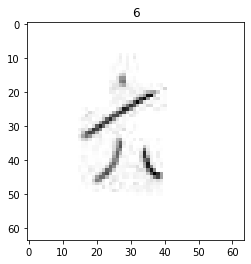

In [16]:
tmps = datagen.flow(X_train, y_train, batch_size=1)
labels = ["零","一","二","三","四","五","六","七","八","九","十","百","千","万","亿"]
for tmp in tmps:
    plt.imshow(tmp[0].squeeze(), cmap=plt.cm.gray)
    plt.title(np.argmax(tmp[1]))  # didn't install Chinese font in my matplotlib, can't use labels[].
    break

### 2.2 CNN architectures
*Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge.*

Here we chose AlexNet (Alex), Ensemble Nets (EnsNet), and ResNet.

#### 2.2.1 AlexNet

In [17]:
### AlexNet style convolutional phase ###

Alex_1 = Sequential(name='Alex_1')

Alex_1.add(Conv2D(filters=8, input_shape = (img_wh,img_wh,1),kernel_size=(3,3), 
                  padding='same', activation='relu', data_format="channels_last"))
Alex_1.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
Alex_1.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))


Alex_1.add(Dropout(0.25))
Alex_1.add(Flatten())
Alex_1.add(Dense(128, activation='relu'))
Alex_1.add(Dropout(0.5))
Alex_1.add(Dense(NUM_CLASSES, activation='softmax'))

Alex_1.compile(loss='categorical_crossentropy',  # 'categorical_crossentropy' 'mean_squared_error'
               optimizer='rmsprop',  # 'adadelta' 'rmsprop'
               metrics=['accuracy']
              )
Alex_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

2021-11-19 16:26:47.458766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
%%time
# the flow method yields batches of images indefinitely, with the given transformations
history_Alex_1 = Alex_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                      steps_per_epoch=int(len(X_train)/64),
                                      epochs=30, verbose=1,
                                      validation_data=(X_test,y_test),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                     )

/users/sxiao/anaconda3/envs/mlenv2021/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-19 16:26:47.724339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-19 16:26:47.725021: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100125000 Hz


Epoch 1/30
175/175 [==============================] - 10s 55ms/step - loss: 2.7633 - accuracy: 0.0848 - val_loss: 2.1805 - val_accuracy: 0.3843
Epoch 2/30
175/175 [==============================] - 8s 46ms/step - loss: 2.2546 - accuracy: 0.2903 - val_loss: 1.6849 - val_accuracy: 0.5064
Epoch 3/30
175/175 [==============================] - 8s 46ms/step - loss: 1.8870 - accuracy: 0.3994 - val_loss: 1.2028 - val_accuracy: 0.6533
Epoch 4/30
175/175 [==============================] - 8s 46ms/step - loss: 1.5471 - accuracy: 0.4976 - val_loss: 0.9639 - val_accuracy: 0.7123
Epoch 5/30
175/175 [==============================] - 8s 46ms/step - loss: 1.3136 - accuracy: 0.5564 - val_loss: 0.7767 - val_accuracy: 0.7581
Epoch 6/30
175/175 [==============================] - 8s 46ms/step - loss: 1.1905 - accuracy: 0.6038 - val_loss: 0.6341 - val_accuracy: 0.8027
Epoch 7/30
175/175 [==============================] - 8s 46ms/step - loss: 1.0632 - accuracy: 0.6428 - val_loss: 0.5789 - val_accuracy: 0.818

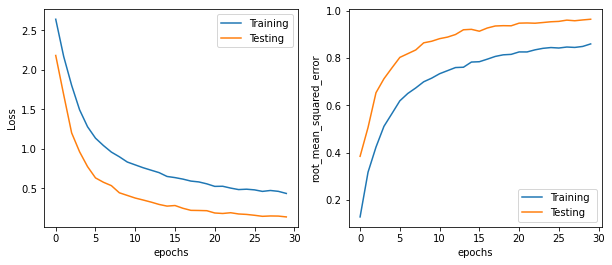

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_Alex_1.history['loss'],label='Training')
plt.plot(history_Alex_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_Alex_1.history['accuracy'],label='Training')
plt.plot(history_Alex_1.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [20]:
### AlexNet style convolutional phase ###

Alex_2 = Sequential(name='Alex_2')

Alex_2.add(Conv2D(filters=64, input_shape = (img_wh,img_wh,1),kernel_size=(3,3), 
                  padding='same', activation='relu', data_format="channels_last"))
Alex_2.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
Alex_2.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
    

# add one layer on flattened output
Alex_2.add(Dropout(0.20))
Alex_2.add(Flatten())
Alex_2.add(Dense(128, activation='relu'))
Alex_2.add(Dropout(0.40))
Alex_2.add(Dense(64, activation='relu'))
Alex_2.add(Dropout(0.60))
Alex_2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
Alex_2.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy']
               )
Alex_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [21]:
%%time

history_Alex_2 = Alex_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                      steps_per_epoch=int(len(X_train)/64),
                                      epochs=30, verbose=1,
                                      validation_data=(X_test,y_test),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                     )

Epoch 1/30
175/175 [==============================] - 55s 309ms/step - loss: 3.2053 - accuracy: 0.0779 - val_loss: 2.2518 - val_accuracy: 0.4480
Epoch 2/30
175/175 [==============================] - 54s 307ms/step - loss: 2.2596 - accuracy: 0.2596 - val_loss: 1.1636 - val_accuracy: 0.6768
Epoch 3/30
175/175 [==============================] - 53s 303ms/step - loss: 1.6003 - accuracy: 0.4573 - val_loss: 0.7532 - val_accuracy: 0.7693
Epoch 4/30
175/175 [==============================] - 53s 305ms/step - loss: 1.2876 - accuracy: 0.5587 - val_loss: 0.5626 - val_accuracy: 0.8205
Epoch 5/30
175/175 [==============================] - 54s 307ms/step - loss: 1.1100 - accuracy: 0.6182 - val_loss: 0.4754 - val_accuracy: 0.8544
Epoch 6/30
175/175 [==============================] - 54s 306ms/step - loss: 0.9871 - accuracy: 0.6640 - val_loss: 0.4260 - val_accuracy: 0.8651
Epoch 7/30
175/175 [==============================] - 53s 305ms/step - loss: 0.8271 - accuracy: 0.7079 - val_loss: 0.3411 - val_ac

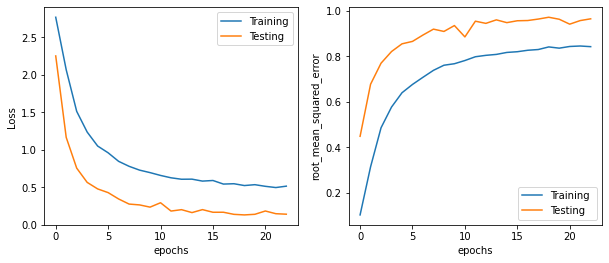

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_Alex_2.history['loss'],label='Training')
plt.plot(history_Alex_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_Alex_2.history['accuracy'],label='Training')
plt.plot(history_Alex_2.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.2 ResNet

In [29]:
### ResNet-Style Bypass ###

input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=8, input_shape = (img_wh,img_wh,1), kernel_size=(3,3),
           kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda),
           padding='same', activation='relu', data_format="channels_last")(input_holder)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)
x = Conv2D(filters=8, kernel_size=(3,3), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Conv2D(filters=16, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same', activation='relu', 
           data_format="channels_last")(x_split)
x = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)
x = Conv2D(filters=8, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)


x = Add()([x, x_split])
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

ResNet_1 = Model(inputs=input_holder, outputs=x, name='ResNet_1')
ResNet_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
ResNet_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 64, 64, 8)    80          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 32, 32, 8)    0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 8)    584         max_pooling2d_16[0][0]           
____________________________________________________________________________________________

In [30]:
%%time

# the flow method yields batches of images indefinitely, with the given transofmrations
history_ResNet_1 = ResNet_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 9s 46ms/step - loss: 2.6013 - accuracy: 0.1467 - val_loss: 1.6552 - val_accuracy: 0.5139
Epoch 2/30
175/175 [==============================] - 8s 45ms/step - loss: 1.8132 - accuracy: 0.4248 - val_loss: 1.0933 - val_accuracy: 0.6733
Epoch 3/30
175/175 [==============================] - 8s 45ms/step - loss: 1.3854 - accuracy: 0.5406 - val_loss: 0.7846 - val_accuracy: 0.7563
Epoch 4/30
175/175 [==============================] - 8s 45ms/step - loss: 1.1057 - accuracy: 0.6240 - val_loss: 0.6086 - val_accuracy: 0.8003
Epoch 5/30
175/175 [==============================] - 8s 45ms/step - loss: 0.9447 - accuracy: 0.6815 - val_loss: 0.5811 - val_accuracy: 0.8053
Epoch 6/30
175/175 [==============================] - 8s 45ms/step - loss: 0.8241 - accuracy: 0.7138 - val_loss: 0.4509 - val_accuracy: 0.8501
Epoch 7/30
175/175 [==============================] - 8s 44ms/step - loss: 0.7185 - accuracy: 0.7519 - val_loss: 0.3404 - val_accuracy: 0.8896

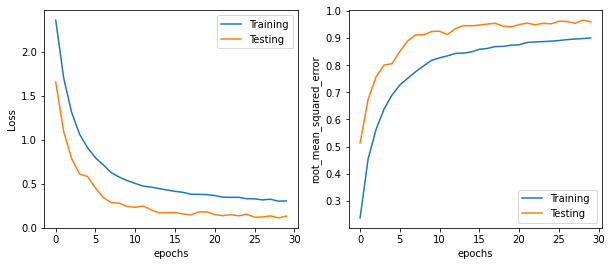

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_1.history['loss'],label='Training')
plt.plot(history_ResNet_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_1.history['accuracy'],label='Training ')
plt.plot(history_ResNet_1.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [32]:
%%time

input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=64, input_shape = (img_wh,img_wh,1), kernel_size=(3,3),
           kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda),
           padding='same', activation='relu', data_format="channels_last")(input_holder)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)
x = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Conv2D(filters=128, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same', activation='relu', 
           data_format="channels_last")(x_split)
x = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)
x = Conv2D(filters=64, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)


x = Add()([x, x_split])
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.20)(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)
x  = Dropout(0.40)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x  = Dropout(0.60)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)


ResNet_2 = Model(inputs=input_holder, outputs=x, name='ResNet_2')
ResNet_2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
ResNet_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 64, 64, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 32, 32, 64)   0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 32, 32, 64)   36928       max_pooling2d_19[0][0]           
____________________________________________________________________________________________

In [33]:
%%time

# the flow method yields batches of images indefinitely, with the given transofmrations
history_ResNet_2 = ResNet_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 15s 81ms/step - loss: 2.7251 - accuracy: 0.1604 - val_loss: 0.6355 - val_accuracy: 0.7747
Epoch 2/30
175/175 [==============================] - 14s 78ms/step - loss: 0.9128 - accuracy: 0.6781 - val_loss: 0.3445 - val_accuracy: 0.8859
Epoch 3/30
175/175 [==============================] - 14s 78ms/step - loss: 0.4960 - accuracy: 0.8208 - val_loss: 0.2706 - val_accuracy: 0.9072
Epoch 4/30
175/175 [==============================] - 14s 77ms/step - loss: 0.3553 - accuracy: 0.8828 - val_loss: 0.1940 - val_accuracy: 0.9275
Epoch 5/30
175/175 [==============================] - 14s 77ms/step - loss: 0.2595 - accuracy: 0.9169 - val_loss: 0.0999 - val_accuracy: 0.9621
Epoch 6/30
175/175 [==============================] - 14s 77ms/step - loss: 0.1921 - accuracy: 0.9422 - val_loss: 0.0648 - val_accuracy: 0.9795
Epoch 7/30
175/175 [==============================] - 13s 77ms/step - loss: 0.1754 - accuracy: 0.9482 - val_loss: 0.0623 - val_accuracy:

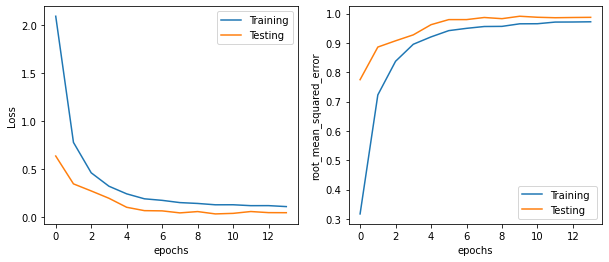

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_2.history['loss'],label='Training')
plt.plot(history_ResNet_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_2.history['accuracy'],label='Training')
plt.plot(history_ResNet_2.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.3 EnsNet

In [23]:
### Ensemble Nets ###

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=16,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=16,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=16,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=16,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
    x = Dense(32, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

EnsNet_1 = Model(inputs=input_holder, outputs=x, name='EnsNet_1')
EnsNet_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
EnsNet_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 16)   2320        conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_5[0][0]                   
______________________________________________________________________________________________

In [24]:
%%time

history_EnsNet_1 = EnsNet_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1, validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 12s 52ms/step - loss: 2.8421 - accuracy: 0.1667 - val_loss: 1.0656 - val_accuracy: 0.6613
Epoch 2/30
175/175 [==============================] - 9s 50ms/step - loss: 0.8956 - accuracy: 0.7042 - val_loss: 0.4702 - val_accuracy: 0.8376
Epoch 3/30
175/175 [==============================] - 9s 50ms/step - loss: 0.4719 - accuracy: 0.8445 - val_loss: 0.1837 - val_accuracy: 0.9456
Epoch 4/30
175/175 [==============================] - 9s 50ms/step - loss: 0.3005 - accuracy: 0.9030 - val_loss: 0.1199 - val_accuracy: 0.9616
Epoch 5/30
175/175 [==============================] - 9s 49ms/step - loss: 0.2268 - accuracy: 0.9266 - val_loss: 0.0954 - val_accuracy: 0.9709
Epoch 6/30
175/175 [==============================] - 9s 49ms/step - loss: 0.1813 - accuracy: 0.9419 - val_loss: 0.0961 - val_accuracy: 0.9704
Epoch 7/30
175/175 [==============================] - 9s 50ms/step - loss: 0.1500 - accuracy: 0.9502 - val_loss: 0.1334 - val_accuracy: 0.958

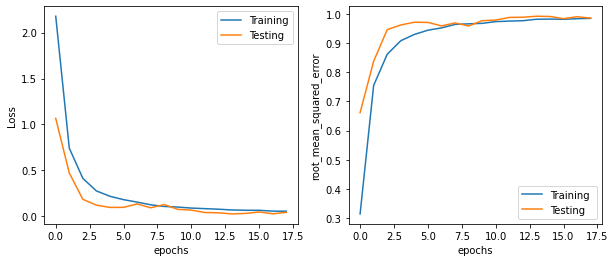

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_EnsNet_1.history['loss'],label='Training')
plt.plot(history_EnsNet_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_EnsNet_1.history['accuracy'],label='Training')
plt.plot(history_EnsNet_1.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [26]:
### Ensemble Nets ###

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=128,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
    x = Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

EnsNet_2 = Model(inputs=input_holder, outputs=x, name='EnsNet_2')
EnsNet_2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
EnsNet_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [27]:
%%time

history_EnsNet_2 = EnsNet_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1, validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 56s 298ms/step - loss: 4.8364 - accuracy: 0.1355 - val_loss: 0.7308 - val_accuracy: 0.7405
Epoch 2/30
175/175 [==============================] - 51s 292ms/step - loss: 1.0993 - accuracy: 0.6531 - val_loss: 0.2659 - val_accuracy: 0.9136
Epoch 3/30
175/175 [==============================] - 51s 293ms/step - loss: 0.6041 - accuracy: 0.8003 - val_loss: 0.2001 - val_accuracy: 0.9301
Epoch 4/30
175/175 [==============================] - 51s 293ms/step - loss: 0.3695 - accuracy: 0.8796 - val_loss: 0.1729 - val_accuracy: 0.9440
Epoch 5/30
175/175 [==============================] - 51s 292ms/step - loss: 0.2927 - accuracy: 0.9116 - val_loss: 0.0625 - val_accuracy: 0.9819
Epoch 6/30
175/175 [==============================] - 51s 291ms/step - loss: 0.2192 - accuracy: 0.9322 - val_loss: 0.0567 - val_accuracy: 0.9848
Epoch 7/30
175/175 [==============================] - 51s 293ms/step - loss: 0.1996 - accuracy: 0.9436 - val_loss: 0.0727 - val_ac

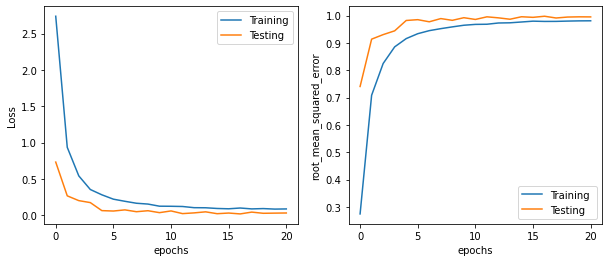

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_EnsNet_2.history['loss'],label='Training')
plt.plot(history_EnsNet_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_EnsNet_2.history['accuracy'],label='Training')
plt.plot(history_EnsNet_2.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

### 2.3 Visualization and Comparison
*Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.*
### 2.3.1 Visualization

In [39]:
# visualize

def visualize_models(X_test, y_test, model_names=[], labels='auto'):
    
    assert isinstance(model_names, list)
    assert all(isinstance(name, str) for name in model_names)
    assert isinstance(y_test[0], np.int64)
    
    height = ceil(len(model_names)/2)
    
    plt.figure(figsize=(20,6*height))
    
    for i, name in enumerate(model_names):
        model = eval(name)
        yhat_model = np.argmax(model.predict(X_test), axis=1)
        acc_model = mt.accuracy_score(y_test,yhat_model)
        plt.subplot(height,2,i+1)
        cm = mt.confusion_matrix(y_test,yhat_model)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels,
                    cmap = sns.color_palette("YlOrBr", as_cmap=True))
        plt.title(f'{str(name)}: {acc_model}', fontsize=20)
    plt.tight_layout()

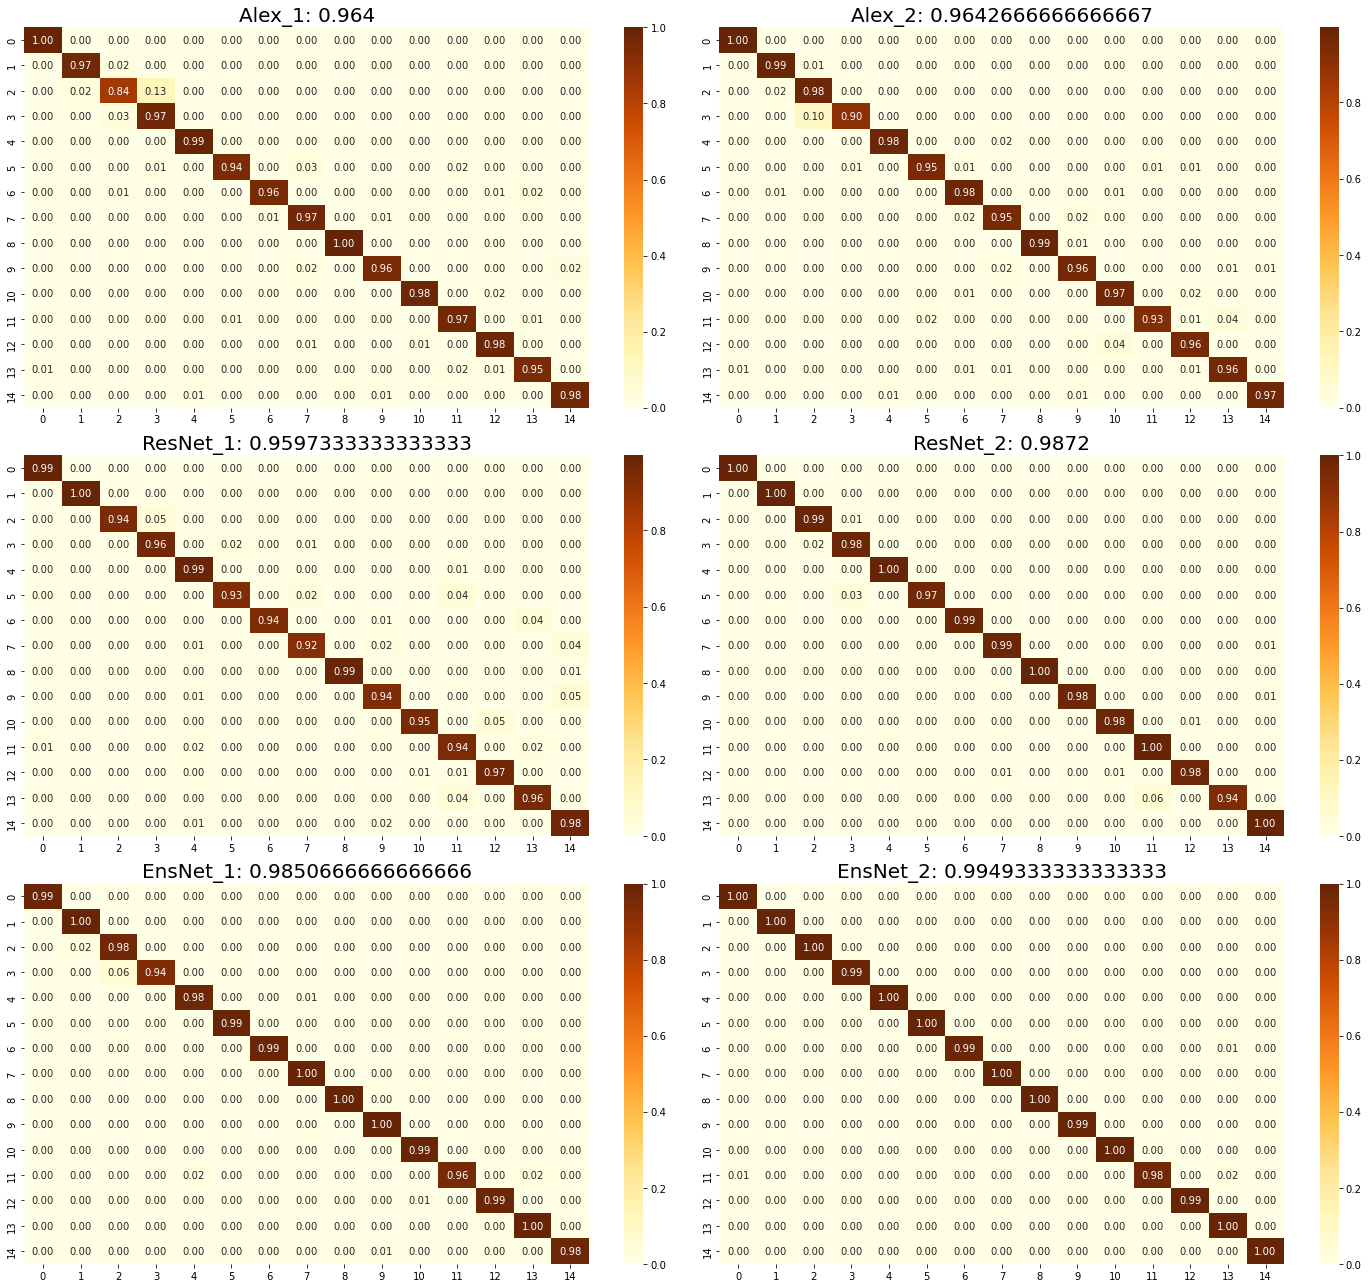

In [41]:
# have to use y_ori since it's 
visualize_models(X_test, y_ori[test_idx_list[0]], labels='auto',
                 model_names=['Alex_1', 'Alex_2', 'ResNet_1', 'ResNet_2', 'EnsNet_1', 'EnsNet_2'])

### 2.3.2 Comparison

In [36]:
f1_score(y_ori[test_idx_list[0]], yhat_ResNet_1, average=None)

# or else

NameError: name 'yhat_ResNet_1' is not defined

In [ ]:
# define a function to get cross map of test.

In [42]:
# Define a function for McNemar's Test
# confidence:           0.90  0.95  0.99
# 1DOF critical value: 2.706 3.841 6.635

def mn_test(ypred1, ypred2, ytrue):
    tab_b = sum((ypred1 == ytrue) & (ypred2 != ytrue))
    tab_c = sum((ypred1 != ytrue) & (ypred2 == ytrue))

    if tab_b + tab_c == 0:
        chi2 = 0
    else:
        chi2 = (abs(tab_b - tab_c)-1)**2 / (tab_b + tab_c)
    
    return round(chi2,4)

In [43]:
yhat_Alex_1 = np.argmax(Alex_1.predict(X_test), axis=1)
yhat_Alex_2 = np.argmax(Alex_2.predict(X_test), axis=1)
yhat_ResNet_1 = np.argmax(ResNet_1.predict(X_test), axis=1)
yhat_ResNet_2 = np.argmax(ResNet_2.predict(X_test), axis=1)
yhat_EnsNet_1 = np.argmax(EnsNet_1.predict(X_test), axis=1)
yhat_EnsNet_2 = np.argmax(EnsNet_2.predict(X_test), axis=1)

First, as we can see, more filters (or larger parameters) bring better accuracy, we would like to compare between same architecture with different parameters.

In [59]:
print(mn_test(yhat_Alex_1, yhat_Alex_2, y_ori[test_idx_list[0]]))
print(mn_test(yhat_ResNet_1, yhat_ResNet_2, y_ori[test_idx_list[0]]))
print(mn_test(yhat_EnsNet_1, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

0.0
60.8421
19.9385


As we can see, `ResNet_2` and `EnsNet_2` are different from `ResNet_1` and `EnsNet_2`, respectively. While these two have higher accuracy, we would say they have better perfromance. For `Alex_1` and `Alex_2`, both models have similar accuracy, and the $\chi^2$ value is 0.0, which means no difference.

Let's compare `ResNet_2` and `EnsNet_2`.

In [67]:
print(mn_test(yhat_ResNet_2, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

12.8525


$\chi^2$ value larger than 6.635, so we can say they are different by 99% confidence, and EnsNet_2 is better.

### 2.4 CNN vs. MLP
*Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.*

Let's first implement a MLP.

In [ ]:
## Extremely bad
## Think more

In [33]:
l2_lambda = 0.0000001

input_holder = Input(shape=(img_wh, img_wh, 1))
x = Flatten()(input_holder)

x = Dense(2048, 
          activation='relu',
          kernel_initializer='he_uniform',
          kernel_regularizer=l2(l2_lambda)
        )(x)
x = Dropout(0.10)(x) # add some dropout for regularization after conv layers
x = Dense(512,
          activation='relu',
          kernel_initializer='he_uniform',
          kernel_regularizer=l2(l2_lambda)
        )(x)
x = Dropout(0.20)(x)
x = Dense(128,
          activation='relu',
          kernel_initializer='he_uniform',
          kernel_regularizer=l2(l2_lambda)
        )(x)
x = Dropout(0.40)(x)
x = Dense(32,
          activation='relu',
          kernel_initializer='he_uniform',
          kernel_regularizer=l2(l2_lambda)
        )(x)
x = Dropout(0.60)(x)
x = Dense(NUM_CLASSES,
          activation='relu',
          kernel_initializer='he_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

MLP = Model(inputs=input_holder, outputs=x, name='MLP')

MLP.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
            optimizer='adadelta', # 'adadelta' 'rmsprop'
            metrics=['accuracy']
           )

MLP.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664   

In [22]:
%%time

history_MLP = MLP.fit_generator(datagen.flow(X_train, y_train, batch_size=64), 
                                steps_per_epoch=int(len(X_train)/64),
                                epochs=30, verbose=1, validation_data=(X_test,y_test),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                               )

Epoch 1/30
175/175 [==============================] - 8s 45ms/step - loss: 8.7082 - accuracy: 0.0732 - val_loss: 7.2874 - val_accuracy: 0.0629
Epoch 2/30
175/175 [==============================] - 8s 43ms/step - loss: 8.3571 - accuracy: 0.0649 - val_loss: 7.0303 - val_accuracy: 0.0603
Epoch 3/30
175/175 [==============================] - 8s 44ms/step - loss: 7.6396 - accuracy: 0.0623 - val_loss: 6.6037 - val_accuracy: 0.0576
Epoch 4/30
175/175 [==============================] - 8s 44ms/step - loss: 7.1405 - accuracy: 0.0666 - val_loss: 6.1353 - val_accuracy: 0.0613
Epoch 5/30
175/175 [==============================] - 8s 44ms/step - loss: 6.5854 - accuracy: 0.0666 - val_loss: 5.5457 - val_accuracy: 0.0605
Epoch 6/30
175/175 [==============================] - 8s 44ms/step - loss: 6.3445 - accuracy: 0.0686 - val_loss: 5.2424 - val_accuracy: 0.0608
Epoch 7/30
175/175 [==============================] - 8s 44ms/step - loss: 6.3168 - accuracy: 0.0616 - val_loss: 4.8692 - val_accuracy: 0.0627

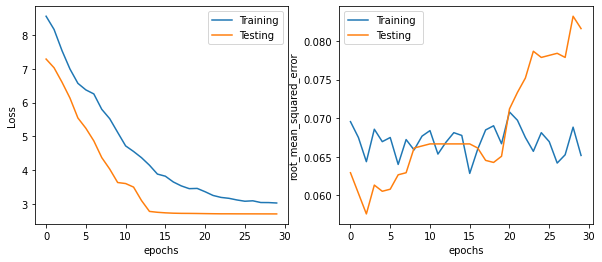

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_MLP.history['loss'],label='Training')
plt.plot(history_MLP.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_MLP.history['accuracy'],label='Training')
plt.plot(history_MLP.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [34]:
history_MLP_ = MLP.fit(X_train, y_train, 
                       epochs=30, verbose=1, validation_data=(X_test,y_test),
                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                      )

Epoch 1/30
352/352 [==============================] - 10s 26ms/step - loss: 8.8757 - accuracy: 0.0691 - val_loss: 8.4589 - val_accuracy: 0.0667
Epoch 2/30
352/352 [==============================] - 9s 25ms/step - loss: 8.6805 - accuracy: 0.0691 - val_loss: 8.7271 - val_accuracy: 0.0669
Epoch 3/30
352/352 [==============================] - 9s 25ms/step - loss: 8.8113 - accuracy: 0.0649 - val_loss: 8.3806 - val_accuracy: 0.0581
Epoch 4/30
352/352 [==============================] - 9s 25ms/step - loss: 8.5847 - accuracy: 0.0669 - val_loss: 7.2211 - val_accuracy: 0.0664
Epoch 5/30
352/352 [==============================] - 9s 25ms/step - loss: 8.4318 - accuracy: 0.0680 - val_loss: 6.4211 - val_accuracy: 0.0664
Epoch 6/30
352/352 [==============================] - 9s 25ms/step - loss: 8.1961 - accuracy: 0.0657 - val_loss: 6.1806 - val_accuracy: 0.0664
Epoch 7/30
352/352 [==============================] - 9s 25ms/step - loss: 8.0177 - accuracy: 0.0618 - val_loss: 6.1557 - val_accuracy: 0.066

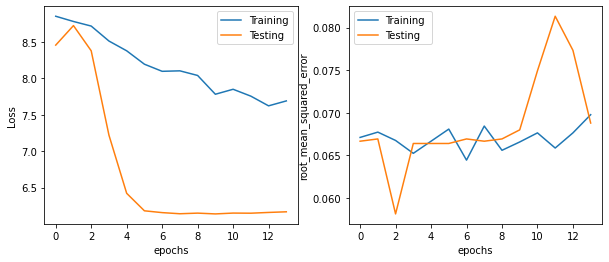

In [35]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_MLP_.history['loss'],label='Training')
plt.plot(history_MLP_.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_MLP_.history['accuracy'],label='Training')
plt.plot(history_MLP_.history['val_accuracy'],label='Testing')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epochs')
plt.legend()

plt.show()

## Excepional work (Transfer learning)

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


In [89]:
# only need to change X to 3 channels
# use the preprocessed y

X_list_tl = []
for file in image_files:
    code = int(file.split('.jpg')[0].split('_')[-1])
    img_path = 'data/image/' + file
    img = cv2.imread(img_path)
    X_list_tl.append(img)
    # ResNet requires: exactly 3 inputs channels, and width and height no smaller than 32.
    # valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)
    # didn't zero mean, because of the requirement of VGG19

X_tl = np.array(X_list_tl)

In [90]:
X_tl[0].shape

(64, 64, 3)

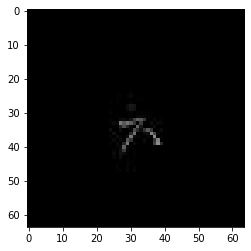

In [95]:
plt.imshow(X_tl[0])

In [105]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

import tensorflow.keras.applications
# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [107]:
X_train_tl = X_tl[train_idx_list[0]]
X_test_tl = X_tl[test_idx_list[0]]

In [109]:
x_train_up = preprocess_input(X_train_tl)
x_test_up = preprocess_input(X_test_tl)

In [110]:
%%time

x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(11250, 2, 2, 2048)
CPU times: user 7min 53s, sys: 47.3 s, total: 8min 41s
Wall time: 26.6 s


In [138]:
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Flatten, Dense
from tensorflow.keras.layers import average, concatenate


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(2000, activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

ResNet_tl = Model(inputs=input_x, outputs=predictions, name='ResNet_tl')

ResNet_tl.summary()

Model: "ResNet_tl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 2, 2, 2048)]      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 2000)              16386000  
_________________________________________________________________
dropout_8 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               400200    
_________________________________________________________________
dense_29 (Dense)             (None, 15)                3015      
Total params: 16,789,215
Trainable params: 16,789,215
Non-trainable params: 0
_____________________________________________

In [139]:
ResNet_tl.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy']
                 )

In [154]:
%%time

history_ResNet_tl = ResNet_tl.fit(x_train_resnet, y_train, epochs=30, batch_size=64,
                                  verbose=1, validation_data=(x_test_resnet,y_test),
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                 )

Epoch 1/30
176/176 [==============================] - 7s 42ms/step - loss: 0.1042 - accuracy: 0.9812 - val_loss: 0.3483 - val_accuracy: 0.9619
Epoch 2/30
176/176 [==============================] - 7s 41ms/step - loss: 0.1128 - accuracy: 0.9804 - val_loss: 0.3169 - val_accuracy: 0.9605
Epoch 3/30
176/176 [==============================] - 7s 41ms/step - loss: 0.0855 - accuracy: 0.9830 - val_loss: 0.3701 - val_accuracy: 0.9611
Epoch 4/30
176/176 [==============================] - 7s 41ms/step - loss: 0.1179 - accuracy: 0.9813 - val_loss: 0.3283 - val_accuracy: 0.9669
Epoch 5/30
176/176 [==============================] - 7s 41ms/step - loss: 0.0941 - accuracy: 0.9828 - val_loss: 0.3906 - val_accuracy: 0.9640
Epoch 6/30
176/176 [==============================] - 7s 41ms/step - loss: 0.0942 - accuracy: 0.9823 - val_loss: 0.3879 - val_accuracy: 0.9661
CPU times: user 14min 3s, sys: 4min 36s, total: 18min 40s
Wall time: 44 s


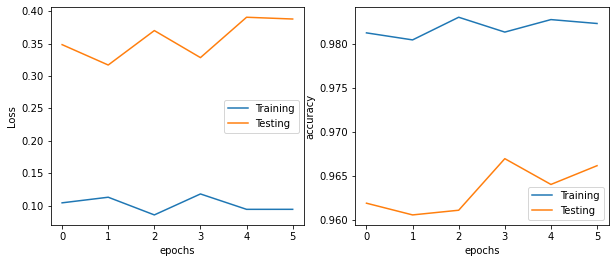

In [155]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_tl.history['loss'],label='Training')
plt.plot(history_ResNet_tl.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_tl.history['accuracy'],label='Training')
plt.plot(history_ResNet_tl.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [156]:

# compare ensnet_2 and resnet_tl